Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [4]:
# copy file from Google Drive to colab
%cd /content
!cp -r "/content/gdrive/My Drive/Colab Notebooks/AICourse/C7M4-Melanoma Detection Assignment/CNN_assignment.zip" .
!ls

/content
CNN_assignment.zip  gdrive  sample_data


In [5]:
!rm -rf "Skin cancer ISIC The International Skin Imaging Collaboration"
!unzip -qn CNN_assignment.zip
!ls

 CNN_assignment.zip
 gdrive
 sample_data
'Skin cancer ISIC The International Skin Imaging Collaboration'


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size = (img_width, img_height),
    validation_split=0.2,
    subset='training',
    seed=123,
    label_mode='categorical',
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size = (img_width, img_height),
    validation_split=0.2,
    subset='validation',
    seed=123,
    label_mode='categorical',
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
Visualize one instance of all the nine classes present in the dataset

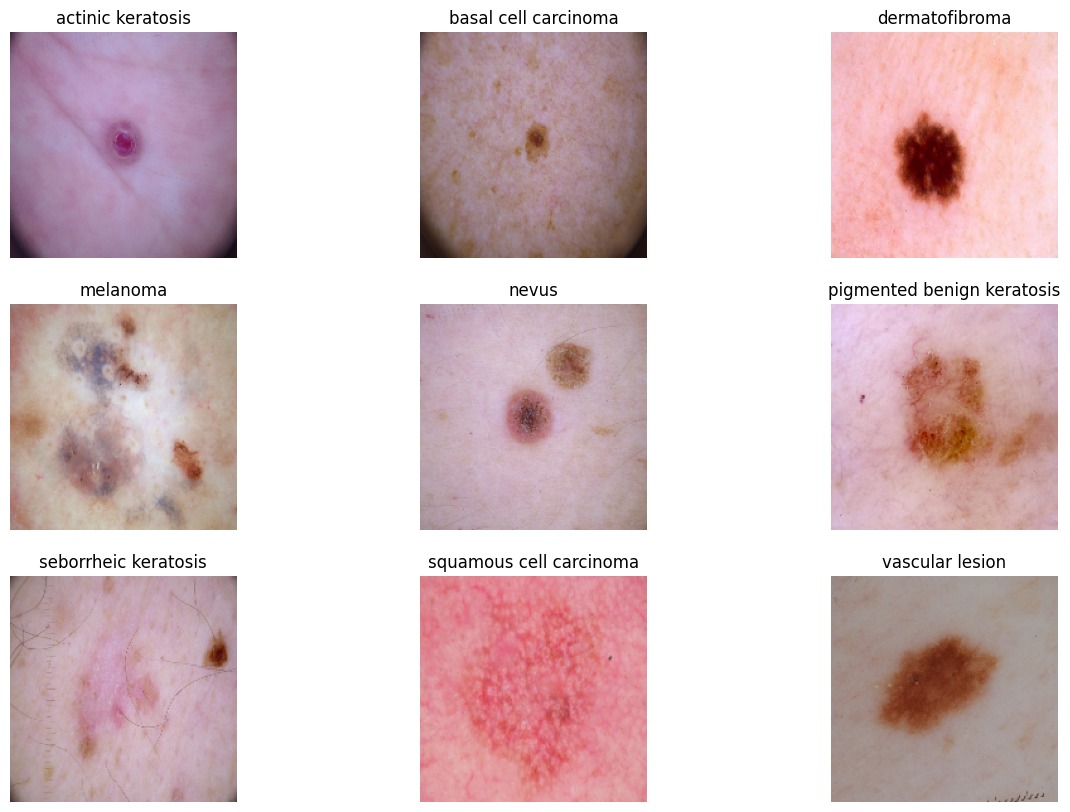

In [12]:
sample_images = {}

for class_name in class_names:
    # Find the first image for the current class
    found = False
    for images, labels in train_ds:
        for label in labels:
            if label[class_names.index(class_name)] == 1:
                sample_images[class_name] = images[0].numpy()
                found = True
                break
        if found:
            break

plt.figure(figsize=(15, 10))
for i, (class_name, image) in enumerate(sample_images.items(), 1):
    plt.subplot(3, 3, i)
    plt.imshow(image.astype("uint8"))
    plt.title(class_name)
    plt.axis("off")

plt.show()

In [13]:
print(train_ds.take(1))

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)

In [16]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.regularizers import l2

In [17]:
model = Sequential()

model.add(Input(shape=(img_width, img_height, 3))),
rescale,

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                       

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 161ms/step - loss: 2.5716 - accuracy: 0.3906 - val_loss: 6.0947 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 1.2616 - accuracy: 0.5519 - val_loss: 6.6831 - val_accuracy: 0.1969
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 0.9125 - accuracy: 0.6523 - val_loss: 3.3299 - val_accuracy: 0.2617
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 0.6267 - accuracy: 0.7762 - val_loss: 1.5231 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 0.4551 - accuracy: 0.8393 - val_loss: 6.3577 - val_accuracy: 0.1902
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 0.2698 - accuracy: 0.9051 - val_loss: 1.9187 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 0.1782 - accuracy: 0.9325 - val_loss: 2.0040 - val_accuracy: 0.4564
Epoch 8/20


### Visualizing training results

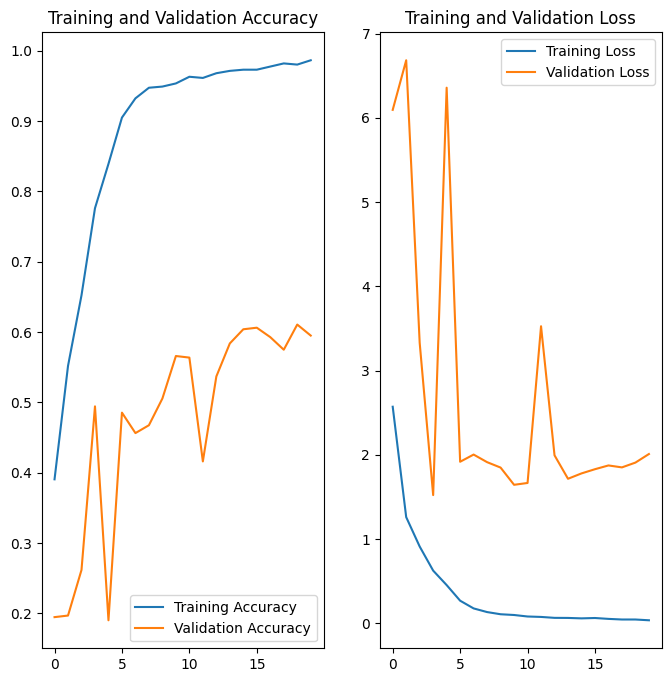

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

As we can see, the accuracy of training data vs validation data have a big difference, so it is **OVERFIT** obviously.

### Using **dropout** and **l2**
to solve the overfitting issue.


In [22]:
model = Sequential()

model.add(Input(shape=(img_width, img_height, 3))),
rescale,

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compiling the model

In [23]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 152ms/step - loss: 17.4490 - accuracy: 0.2779 - val_loss: 21.1060 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 8s 149ms/step - loss: 11.7443 - accuracy: 0.4018 - val_loss: 16.3816 - val_accuracy: 0.2013
Epoch 3/20
56/56 [==============================] - 9s 154ms/step - loss: 11.3043 - accuracy: 0.4699 - val_loss: 12.2477 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 8s 148ms/step - loss: 10.9630 - accuracy: 0.5095 - val_loss: 12.0870 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 8s 149ms/step - loss: 10.6361 - accuracy: 0.5564 - val_loss: 11.1143 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 8s 149ms/step - loss: 10.3927 - accuracy: 0.5887 - val_loss: 10.6860 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 8s 147ms/step - loss: 10.1167 - accuracy: 0.6060 - val_loss: 11.4062 - val_accuracy

### Visualizing the results

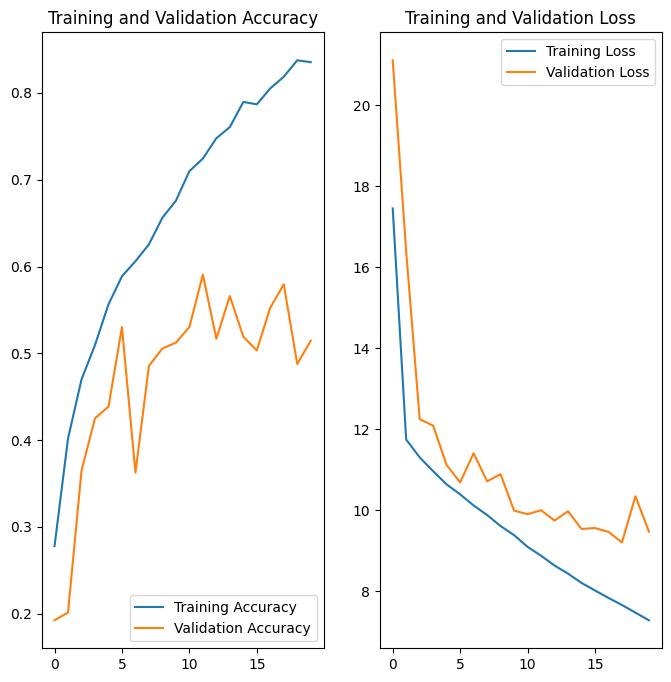

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Compare to the previous model, the new one is **more stable** and overfit issue is alleviated. But **overfitting** is still existed.

#### Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
class_counts = [0] * len(class_names)

for images, labels in train_ds:
    for label in labels:
        class_counts[tf.argmax(label).numpy()] += 1

total = sum(class_counts)
# Print the class names and their corresponding counts
for class_name, count in zip(class_names, class_counts):
    print(f"Class: {class_name}, Count: {count}, Percent: {round(count/total, 2)}")

Class: actinic keratosis, Count: 92, Percent: 0.05
Class: basal cell carcinoma, Count: 309, Percent: 0.17
Class: dermatofibroma, Count: 77, Percent: 0.04
Class: melanoma, Count: 352, Percent: 0.2
Class: nevus, Count: 277, Percent: 0.15
Class: pigmented benign keratosis, Count: 370, Percent: 0.21
Class: seborrheic keratosis, Count: 58, Percent: 0.03
Class: squamous cell carcinoma, Count: 142, Percent: 0.08
Class: vascular lesion, Count: 115, Percent: 0.06


As we can see,
- **seborrheic keratosis** has `3%`, the least number of samples
- **pigmented benign keratosis** dominate `21%`, the data in terms propotionate number of samples.


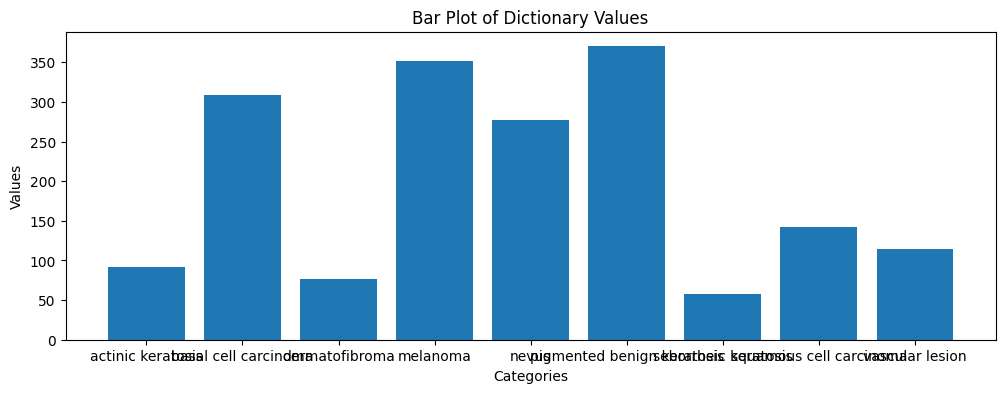

In [27]:
classes = dict(zip(class_names, class_counts))
labels = list(classes.keys())
values = list(classes.values())

fig = plt.figure(figsize=(12, 4))

# Create a bar plot
plt.bar(labels, values)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot of Dictionary Values')

# Show the plot
plt.show()

As we can see from the picture, the data distribution is **unbalanced**.

### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train.joinpath(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC421DB0DC0>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC421C75BD0>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC43E83BA00>: 100%|██████████| 500/500 [00:24<00:00, 20.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC421C66D40>: 100%|██████████| 500/500 [01:21<00:00,  6.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FC4D41A7D60>: 100%|██████████| 500/500 [01:13<00:00,  6.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC43C140340>: 100%|██████████| 500/500 [00:15<00:00, 31.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC4D41F9990>: 100%|██████████| 500/500 [00:39<00:00, 12.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4203AE170>: 100%|██████████| 500/500 [00:15<00:00, 33.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4D41F82B0>: 100%|██████████| 500/500 [00:15<00:00, 32.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

Create training dataset

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size = (img_width, img_height),
    validation_split=0.2,
    subset='training',
    seed=123,
    label_mode='categorical',
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size = (img_width, img_height),
    validation_split=0.2,
    subset='validation',
    seed=123,
    label_mode='categorical',
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [46]:
class_counts = [0] * len(class_names)

for images, labels in train_ds:
    for label in labels:
        class_counts[tf.argmax(label).numpy()] += 1

total = sum(class_counts)
# Print the class names and their corresponding counts
for class_name, count in zip(class_names, class_counts):
    print(f"Class: {class_name}, Count: {count}, Percent: {round(count/total, 2)}")

Class: actinic keratosis, Count: 493, Percent: 0.09
Class: basal cell carcinoma, Count: 721, Percent: 0.13
Class: dermatofibroma, Count: 455, Percent: 0.08
Class: melanoma, Count: 755, Percent: 0.14
Class: nevus, Count: 677, Percent: 0.13
Class: pigmented benign keratosis, Count: 773, Percent: 0.14
Class: seborrheic keratosis, Count: 456, Percent: 0.08
Class: squamous cell carcinoma, Count: 569, Percent: 0.11
Class: vascular lesion, Count: 493, Percent: 0.09


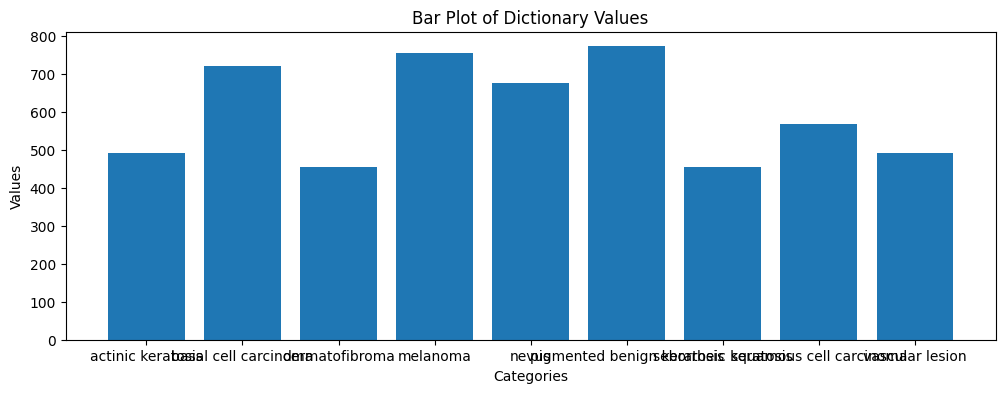

In [47]:
classes = dict(zip(class_names, class_counts))
labels = list(classes.keys())
values = list(classes.values())

fig = plt.figure(figsize=(12, 4))

# Create a bar plot
plt.bar(labels, values)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot of Dictionary Values')

# Show the plot
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### Create your model (make sure to include normalization)

In [49]:
model = Sequential()

model.add(Input(shape=(img_width, img_height, 3))),
rescale,

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [51]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/50
169/169 [==============================] - 41s 228ms/step - loss: 13.4181 - accuracy: 0.3101 - val_loss: 11.8852 - val_accuracy: 0.3200
Epoch 2/50
169/169 [==============================] - 35s 201ms/step - loss: 10.9727 - accuracy: 0.4405 - val_loss: 14.4592 - val_accuracy: 0.2138
Epoch 3/50
169/169 [==============================] - 40s 230ms/step - loss: 10.1570 - accuracy: 0.5158 - val_loss: 13.7016 - val_accuracy: 0.2160
Epoch 4/50
169/169 [==============================] - 34s 194ms/step - loss: 9.4654 - accuracy: 0.5744 - val_loss: 9.8617 - val_accuracy: 0.4885
Epoch 5/50
169/169 [==============================] - 35s 203ms/step - loss: 8.7826 - accuracy: 0.6428 - val_loss: 8.7931 - val_accuracy: 0.6073
Epoch 6/50
169/169 [==============================] - 33s 192ms/step - loss: 8.1914 - accuracy: 0.6808 - val_loss: 8.0533 - val_accuracy: 0.6837
Epoch 7/50
169/169 [==============================] - 34s 198ms/step - loss: 7.6726 - accuracy: 0.7164 - val_loss: 7.7463 - 

#### **Todo:**  Visualize the model results

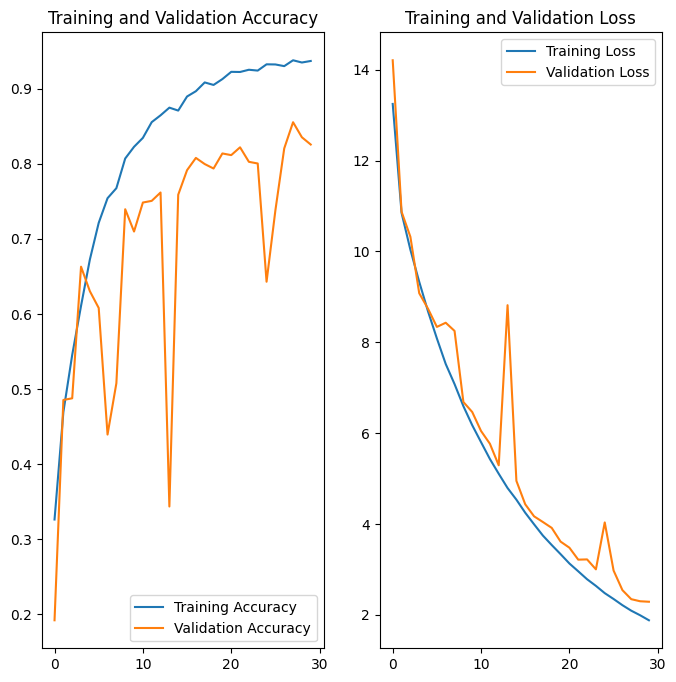

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



As we can see, the gap between accuracy of training data and validation accuracy is smaller than before. we **get rid of overfitting**.

Which means class rebalance is **really help** in this case.